# Colab drive mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/네카라쿠배/최종 프로젝트/code

/content/drive/MyDrive/네카라쿠배/최종 프로젝트/code


In [3]:
ls

Collaborative_Filtering_MF_ALS.ipynb  EDA_sj.ipynb
Collaborative_Filtering_MF_NN.ipynb   __pycache__/
collaborative-filtering-nn.ipynb      set_matplotlib_hangul.py


In [4]:
#!pip install nbformat

# Module import, Pre-Work

In [5]:
from collections import Counter

import numpy as np
import pandas as pd

import scipy.sparse as spr
import pickle

# Load Data

In [6]:
song_meta = pd.read_json("../data/song_meta.json")
train = pd.read_json("../data/train.json")
test = pd.read_json("../data/val.json")

## Data Preprocessing

playlist, song, tag의 id(각각 nid, sid, tid)를 새로 생성하는 이유는, 새로 생성할 id를 matrix의 row, column index로 사용할 것이기 때문입니다.

- plylst_id_nid : playlist id -> nid
- plylst_nid_id : playlist nid -> id
- song_id_sid : song id -> sid
- song_sid_id : song sid -> id
- tag_id_tid : tag id -> tid
- tag_tid_id : tag tid -> id
- song_dict : song id -> count
- tag_dict : tag id -> count

In [7]:
# train + test => new train
plylst = pd.concat([train, test], ignore_index=True)
n_plylst = len(plylst)

# playlist id
plylst["nid"] = range(n_plylst)

# id <-> nid
plylst_id_nid = dict(zip(plylst["id"],plylst["nid"]))
plylst_nid_id = dict(zip(plylst["nid"],plylst["id"]))

In [8]:
plylst_tag = plylst['tags']
tag_counter = Counter([tg for tgs in plylst_tag for tg in tgs])
tag_dict = {x: tag_counter[x] for x in tag_counter}

tag_id_tid = dict()
tag_tid_id = dict()
for i, t in enumerate(tag_dict):
  tag_id_tid[t] = i
  tag_tid_id[i] = t

n_tags = len(tag_dict)

plylst_song = plylst['songs']
song_counter = Counter([sg for sgs in plylst_song for sg in sgs])
song_dict = {x: song_counter[x] for x in song_counter}

song_id_sid = dict()
song_sid_id = dict()
for i, t in enumerate(song_dict):
  song_id_sid[t] = i
  song_sid_id[i] = t

n_songs = len(song_dict)

plylst의 songs와 tags를 새로운 id로 변환하여 DataFrame에 추가합니다

In [9]:
plylst['songs_id'] = plylst['songs'].map(lambda x: [song_id_sid.get(s) for s in x if song_id_sid.get(s) != None])
plylst['tags_id'] = plylst['tags'].map(lambda x: [tag_id_tid.get(t) for t in x if tag_id_tid.get(t) != None])

In [10]:
plylst_use = plylst[['nid','updt_date','songs_id','tags_id']]
plylst_use.loc[:,'num_songs'] = plylst_use['songs_id'].map(len)
plylst_use.loc[:,'num_tags'] = plylst_use['tags_id'].map(len)
plylst_use = plylst_use.set_index('nid')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [11]:
plylst_train = plylst_use.copy()
plylst_train.head()

,updt_date,songs_id,tags_id,num_songs,num_tags
nid,,,,,
0,2013-12-19 18:36:19.000,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[0],19,1
1,2014-12-02 16:19:42.000,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...","[1, 2]",42,2
2,2017-08-28 07:09:34.000,"[61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 7...","[3, 4]",28,2
3,2019-12-05 15:15:18.000,"[89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 1...","[5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",38,10
4,2011-10-25 13:54:56.000,"[127, 128, 129, 130, 131, 132, 133, 134, 135, ...",[15],53,1


In [12]:
train.tail()

,tags,id,plylst_title,songs,like_cnt,updt_date
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000
115070,"[노래추천, 팝송추천, 팝송, 팝송모음]",100389,FAVORITE POPSONG!!!,"[26008, 456354, 324105, 89871, 135272, 143548,...",17,2020-04-18 20:35:06.000


In [13]:
plylst_train[plylst_train['num_songs'] == 0]

,updt_date,songs_id,tags_id,num_songs,num_tags
nid,,,,,
115072,2014-07-16 15:24:24.000,[],[],0,0
115079,2017-02-09 17:33:45.000,[],[133],0,1
115080,2015-06-22 09:11:02.000,[],[],0,0
115088,2016-03-19 23:53:20.000,[],[7054],0,1
115091,2019-12-15 19:15:21.000,[],"[493, 616, 29160]",0,3
...,...,...,...,...,...
138062,2019-06-17 14:22:48.000,[],[],0,0
138063,2015-05-08 00:09:01.000,[],[30],0,1
138067,2016-04-27 15:32:55.000,[],[],0,0


## Make Sparse Matrix with torch.sparse_coo_tenscor

row가 playlist(nid)이고 column이 item(sid or tid)인 sparse matrix A를 만듭니다.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [15]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cpu


In [16]:
row = np.repeat(range(n_plylst), plylst_train['num_songs'])
col = [song for songs in plylst_train['songs_id'] for song in songs]
dat = np.repeat(1, plylst_train['num_songs'].sum())
train_songs_A = torch.sparse_coo_tensor([np.array(row),np.array(col)], dat, (n_plylst, n_songs))

row = np.repeat(range(n_plylst), plylst_train['num_tags'])
col = [tag for tags in plylst_train['tags_id'] for tag in tags]
dat = np.repeat(1, plylst_train['num_tags'].sum())
train_tags_A = torch.sparse_coo_tensor([np.array(row),np.array(col)], dat, (n_plylst, n_tags))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  after removing the cwd from sys.path.


In [17]:
train_songs_A = train_songs_A.coalesce()

In [18]:
# user_emb = nn.Embedding(138086, 100).cuda()
# item_emb = nn.Embedding(638336, 100).cuda()
# users = torch.LongTensor(train_songs_A.indices()[0]).cuda()
# items = torch.LongTensor(train_songs_A.indices()[1]).cuda()

# U = user_emb(users)
# V = item_emb(items)

In [19]:
# U*V

In [20]:
# U.shape, V.shape

### 데이터 샘플 생성 (train + val)

- trian용 100,000개 생성, val용 30,000개 생성 

In [78]:
import random

# 강제로 label이 1인 데이터 추가 (train + val 용)
rand_idx = random.sample(range(5707070), 60000)

random_idx_1 = []
for idx in rand_idx:
    random_idx_1.append((train_songs_A.indices()[0][idx].item(), train_songs_A.indices()[1][idx].item()))

# 나머지 추가
random_idx_0 = []
for _ in range(60000):
    random_idx_0.append((random.randrange(138086), random.randrange(638336)))

In [80]:
len(random_idx_1), len(random_idx_0)

(60000, 60000)

In [81]:
from tqdm import tqdm
user_idx = []
item_idx = []
label = []
# train_data에 label 1 넣기
for x,y in tqdm(random_idx_1[:50000]):
    user_idx.append(x)
    item_idx.append(y)
    label.append(train_songs_A[x][y].item())

# train_data에 label 0 넣기
for x,y in tqdm(random_idx_0[:50000]):
    user_idx.append(x)
    item_idx.append(y)
    label.append(train_songs_A[x][y].item())

train_data = pd.DataFrame({
    'user' : user_idx,
    'item' : item_idx,
    'label' : label
})

100%|██████████| 50000/50000 [19:18<00:00, 43.18it/s]


In [82]:
len(train_data), train_data.label.sum()

(100000, 50004)

- validation용 데이터 20000개 생성

In [83]:
from tqdm import tqdm
user_idx = []
item_idx = []
label = []
# val_data에 label 1 넣기 
for x,y in tqdm(random_idx_1[50000:]):
    user_idx.append(x)
    item_idx.append(y)
    label.append(train_songs_A[x][y].item())

# val_data에 label 0 넣기
for x,y in tqdm(random_idx_0[50000:]):
    user_idx.append(x)
    item_idx.append(y)
    label.append(train_songs_A[x][y].item())

val_data = pd.DataFrame({
    'user' : user_idx,
    'item' : item_idx,
    'label' : label
})

100%|██████████| 10000/10000 [03:50<00:00, 43.29it/s]


In [84]:
import sklearn
train_data = sklearn.utils.shuffle(train_data)
val_data = sklearn.utils.shuffle(val_data)

In [85]:
train_data.to_csv('../data/train_data_sample_100k_5_5.csv')
val_data.to_csv('../data/val_data_sample_20k_5_5.csv')

In [ ]:
import random

# 강제로 label이 1인 데이터 추가
rand_idx = random.sample(range(5707070), 5000)

random_idx = []
for idx in rand_idx:
    random_idx.append((train_songs_A.indices()[0][idx].item(), train_songs_A.indices()[1][idx].item()))

# 나머지 추가
for _ in range(5000):
    random_idx.append((random.randrange(138086), random.randrange(638336)))

len(random_idx)

10000

In [ ]:
from tqdm import tqdm
user_idx = []
item_idx = []
label = []
for x,y in tqdm(random_idx):
    user_idx.append(x)
    item_idx.append(y)
    label.append(train_songs_A[x][y].item())

val_data = pd.DataFrame({
    'user' : user_idx,
    'item' : item_idx,
    'label' : label
})

100%|██████████| 10000/10000 [03:23<00:00, 49.17it/s]


### Train, val data load

In [21]:
data = pd.read_csv('../data/song/train_data_sample.csv', index_col = 0)
val_data = pd.read_csv('../data/song/val_data_sample.csv', index_col = 0)

In [22]:
len(data), data.label.sum()

(10000, 2000)

In [23]:
len(val_data), val_data.label.sum()

(10000, 2001)

In [24]:
import sklearn
data = sklearn.utils.shuffle(data)
val_data = sklearn.utils.shuffle(val_data)

### label이 1인 값의 인덱스를 알려주는 sparse matrix를 이용하여 학습을 해보려고 했던 시도(미니배치)

---

In [26]:
train_songs_A.indices()
train_songs_A.values

<function Tensor.values>

- 배치사이즈 설정후, 미니배치 만들기

In [103]:
import torch
from torch import nn, optim
from sklearn.datasets import load_iris
from torch.utils.data import  TensorDataset, DataLoader
iris = load_iris()
X = iris.data[:100]
y = iris.target[:100]
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
ds = TensorDataset(X, y)
loader = DataLoader(ds, batch_size=10, shuffle=True)

1이 들어있는 위치를 알려주는 sparse matrix를 통해 학습하기 위해, 570만개의 인덱스와 값을 미니배치로 올린다

In [77]:
sparse_matrix= pd.DataFrame({
                'user' : train_songs_A.indices()[0],
                'item' : train_songs_A.indices()[1],
                'label' : train_songs_A.values()
                })

sparse_matrix.tail()

,user,item,label
5707065,138085,37581,1
5707066,138085,41017,1
5707067,138085,45173,1
5707068,138085,46416,1
5707069,138085,63505,1


In [72]:
import torch
from torch import nn, optim
from sklearn.datasets import load_iris
from torch.utils.data import  TensorDataset, DataLoader

X = sparse_matrix[['user','item']].values
y = sparse_matrix['label'].values

X = torch.tensor(X)
y = torch.tensor(y)
ds = TensorDataset(X,y)
train_loader = DataLoader(ds, batch_size = 64, shuffle = True)

In [73]:
first_batch = train_loader.__iter__().__next__()

print('{:15s} | {:<25s} | {}'.format('name','type','size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch','','len(train_loader)'))
print('{:15s} | {:<25s} | {}'.format('first_batch',str(type(first_batch)),len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]',str(type(first_batch[0])),first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]',str(type(first_batch[1])),first_batch[1].shape))

## 설명 ##
# 15s : 15칸 공백을 유지하라 (사이즈 제공)
# <,> : 왼쪽, 오른쪽 정렬을 유지하라

name            | type                      | size
Num of Batch    |                           | len(train_loader)
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([64, 2])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([64])


In [ ]:
for x,y in train_loader:
    print(x,y)
    break

---

### device 확인

In [25]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cpu


## GMF model
- element wise product

In [27]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, n_hidden=20):
        super(GMF, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.lin1 = nn.Linear(emb_size, 2) # log_softmax 쓰러면 출력층을 2로
        #self.drop1 = nn.Dropout(0.1)
        
    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        #x = F.sigmoid(self.lin1(U * V))           #sigmoid (BCE)
        x = F.log_softmax(self.lin1(U*V), dim=1)  #log_softmax (CrossEntropy)
        #x = self.lin1(U*V)                        #linear (BCEwithLogitsLoss)
        #x = self.drop1(x)
        return x

## MF + NN model train

In [28]:
class CollabFNet(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, n_hidden=20):
        super(CollabFNet, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.lin1 = nn.Linear(emb_size*2, n_hidden)
        self.lin2 = nn.Linear(n_hidden, 2)
        #self.drop1 = nn.Dropout(0.1)
        
    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        x = F.relu(torch.cat([U, V], dim=1))
        #x = self.drop1(x)
        x = F.relu(self.lin1(x))
        x = F.log_softmax(self.lin2(x), dim=1) 
        return x

In [29]:
from tqdm import tqdm

train_loss_history = []
val_loss_history = []

def train_epocs(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss() # BCEwithLogitsLoss()

    model.train()


    for i in tqdm(range(epochs)):
        users = torch.LongTensor(data.user.values).to(device)
        items = torch.LongTensor(data.item.values).to(device)
        labels = torch.LongTensor(data.label.values).to(device)
        if unsqueeze:
            labels = labels.unsqueeze(1)
        y_hat = model(users, items).to(device)
        loss = criterion(y_hat, labels) # criterion = nn.CrossEntropyLoss()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('train loss : ', loss.item())
        train_loss_history.append(loss.item())

        ########## validation loss recode ############
        # with torch.no_grad():
        #     val_users = torch.LongTensor(val_data.user.values).to(device)
        #     val_items = torch.LongTensor(val_data.item.values).to(device)
        #     val_labels = torch.LongTensor(val_data.label.values).to(device)
        #     if unsqueeze:
        #         val_labels = val_labels.unsqueeze(1).to(device)
        #     val_y_hat = model(val_users, val_items).to(device)
        #     val_loss = criterion(val_y_hat, val_labels) # criterion = nn.CrossEntropyLoss()
        #     print('val loss : ', val_loss.item()) 
        #     val_loss_history.append(val_loss.item())
        test_loss(model, unsqueeze)

In [30]:
def test_loss(model, unsqueeze=False):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    with torch.no_grad():
        val_users = torch.LongTensor(val_data.user.values).to(device)
        val_items = torch.LongTensor(val_data.item.values).to(device)
        val_labels = torch.LongTensor(val_data.label.values).to(device)
        if unsqueeze:
            val_labels = val_labels.unsqueeze(1)
        y_hat = model(val_users, val_items).to(device)
        val_loss = criterion(y_hat, val_labels)
        val_loss_history.append(val_loss.item())
        print("test loss %.3f " % val_loss.item())

In [32]:
from tqdm import tqdm

def train_epocs_minibatch(model, epochs=10, batch_size = 100000, lr=0.01, wd=0.0, unsqueeze=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropy() #BCEWithLogitsLoss()
    model.train()
    
    n = len(data)
    bs = batch_size
    repeat = (n - 1) // bs + 1
    
    for i in range(epochs):
        for j in range(repeat):
            users = torch.LongTensor(data.user[j * bs: j * bs + bs].reset_index(drop=True))
            items = torch.LongTensor(data.item[j * bs: j * bs + bs].reset_index(drop=True))
            labels = torch.LongTensor(data.label[j * bs: j * bs + bs].reset_index(drop=True))

            if unsqueeze:
                labels = labels.unsqueeze(1)
            y_hat = model(users, items)
            loss = criterion(y_hat, labels) # probabilities, targets
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_history.append(loss.item())
            test_loss(model, unsqueeze)
            print('batch:{}/{}'.format(j+1,repeat), loss.item())
            
        print('===== {} epoch =====\n'.format(i+1))

---

### 미니 batch를 이용한 학습 시도

- 미니 batch를 이용한 학습 시도

In [83]:
batch_size = 64
learning_rate = 0.0001
epoch_num = 15

In [98]:
model = CollabFNet(138086, 638336, emb_size=100).cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
model.train()   # 학습을 시작하겠다는 선언. 여기서부터 학습되는것이 아님
i = 1
for epoch in range(epoch_num):  # 15번 학습
    for data, target in train_loader: # 한번의 epoch안에서, batch로 나눈 12,000개의 데이터 묶음을 학습 반복

        # 미니배치 데이터를 내가 설정한 device로 보내기
        data = data.cuda()
        target = target.cuda()
        print('data:',data)
        optimizer.zero_grad() # gradient 를 0으로 (반복 될때마다 새롭게 갱신)
        output = model(data)
        print('output:',output)
        print('target:',target)
        loss = criterion(output, target) # criterion = nn.CrossEntropyLoss()
        loss.backward()  # loss backpropagation
        optimizer.step() # 가중치 업데이트

        if i % 1000 == 0:
            print('Train Step : {}\tLoss : {:.3f}'.format(i,loss.item()))
        
        i+=1

---

### model 턈색

- 1. embedding size = 100, train_data_size = 10k

In [29]:
model = CollabFNet(138086, 638336, emb_size=100).to(device)

In [ ]:
train_loss_history = []
val_loss_history = []

train_epocs(model, epochs=500, lr=0.001, wd=1e-3, unsqueeze=False) 

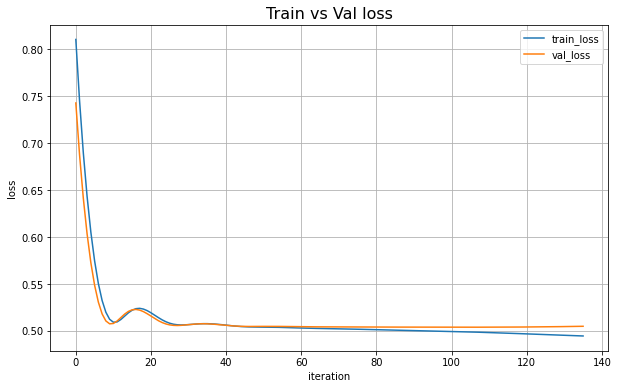

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

iteration = range(len(train_loss_history))
plt.figure(figsize = (10,6))
plt.plot(iteration, train_loss_history, label = 'train_loss')
plt.plot(iteration, val_loss_history, label = 'val_loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.title('Train vs Val loss', size = 16)
plt.grid()
plt.show()

#### 과적합 발생, 해결 방안을 세워보자
    - 1. train_data 수를 늘려보자
    - 2. dropout을 추가해보자

- 2. embedding size = 300, train_data_size = 30k
    - 300이상 설정 시 cuda out of memory : minibatch이용해야 할듯?


In [32]:
model = CollabFNet(138086, 638336, emb_size=300).to(device)

In [ ]:
train_loss_history = []
val_loss_history = []

train_epocs(model, epochs=1000, lr=0.001, wd=0.001, unsqueeze=False) 

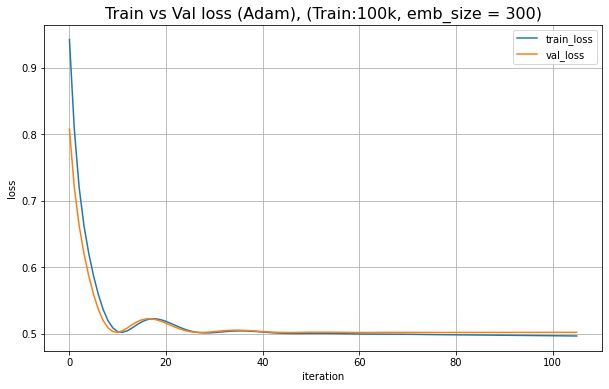

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

iteration = range(len(train_loss_history))
plt.figure(figsize = (10,6))
plt.plot(iteration, train_loss_history, label = 'train_loss')
plt.plot(iteration, val_loss_history, label = 'val_loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.title('Train vs Val loss (Adam), (Train:100k, emb_size = 300)', size = 16)
plt.grid()
plt.show()

- 3. dropout을 이용해보자

In [44]:
# Note here there is no matrix multiplication, we could potentially make the embeddings of different sizes.
# Here we could get better results by keep playing with regularization.
    
class CollabFNet_dropout(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, n_hidden=20):
        super(CollabFNet_dropout, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.lin1 = nn.Linear(emb_size*2, n_hidden)
        self.lin2 = nn.Linear(n_hidden, 2)
        self.drop1 = nn.Dropout(0.2)
        
    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        x = F.relu(torch.cat([U, V], dim=1))
        x = self.drop1(x)
        x = F.relu(self.lin1(x))
        x = self.drop1(x)
        x = F.log_softmax(self.lin2(x), dim=1) 
        return x

In [45]:
dropout_model = CollabFNet_dropout(138086, 638336, emb_size=300).to(device)

In [ ]:
train_loss_history = []
val_loss_history = []

train_epocs(dropout_model, epochs=1000, lr=0.01, wd=1e-4, unsqueeze=False)

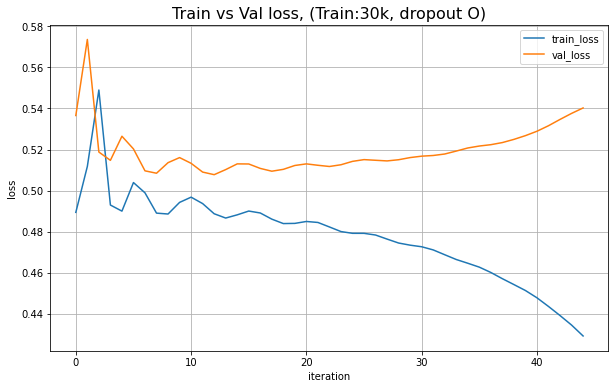

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

iteration = range(len(train_loss_history))
plt.figure(figsize = (10,6))
plt.plot(iteration, train_loss_history, label = 'train_loss')
plt.plot(iteration, val_loss_history, label = 'val_loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.title('Train vs Val loss, (Train:30k, dropout O)', size = 16)
plt.grid()
plt.show()

- 극 초반에 최저의 val_loss를 보여주고 일정 반복 뒤 수렴..?

- 4. layer를 더 여러개 쌓아보기
    - 600(입력) -> 300 -> 100 -> 10 -> 2(출력)

In [31]:
# Note here there is no matrix multiplication, we could potentially make the embeddings of different sizes.
# Here we could get better results by keep playing with regularization.
    
class CollabFNet_L4(nn.Module):
    def __init__(self, num_users, num_items, emb_size=300):
        super(CollabFNet_L4, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.lin1 = nn.Linear(emb_size*2, 300)
        self.lin2 = nn.Linear(300, 100)
        self.lin3 = nn.Linear(100, 10)
        self.lin4 = nn.Linear(10, 2)
        self.drop1 = nn.Dropout(0.1)
        
    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        x = F.relu(torch.cat([U, V], dim=1))
        x = self.drop1(x)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.drop1(x)
        x = F.relu(self.lin3(x))
        x = F.log_softmax(self.lin4(x), dim=1) 
        return x

In [33]:
MLP_model = CollabFNet_L4(138086, 638336, emb_size=300).to(device)

In [ ]:
train_loss_history = []
val_loss_history = []

train_epocs(MLP_model, epochs=400, lr=0.01, wd=1e-4, unsqueeze=False) 

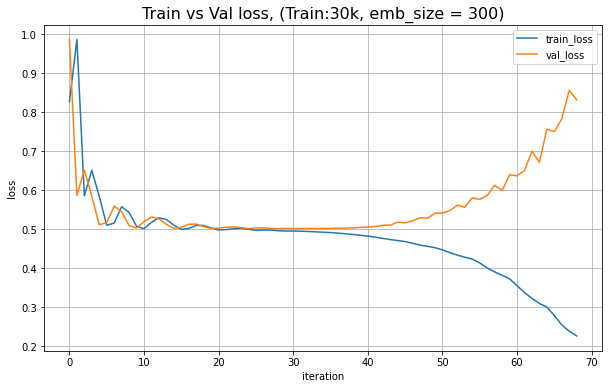

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

iteration = range(len(train_loss_history))
plt.figure(figsize = (10,6))
plt.plot(iteration, train_loss_history, label = 'train_loss')
plt.plot(iteration, val_loss_history, label = 'val_loss')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.legend()
plt.title('Train vs Val loss, (Train:30k, emb_size = 300)', size = 16)
plt.grid()
plt.show()

- 5. GMF 모델 이용해보자

- BCELoss() 이용하기

In [36]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, n_hidden=20):
        super(GMF, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.lin1 = nn.Linear(emb_size, 1) # log_softmax 쓰러면 출력층을 2로
        #self.drop1 = nn.Dropout(0.1)
        
    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        x = F.sigmoid(self.lin1(U * V))           #sigmoid (BCE)
        #x = F.log_softmax(self.lin1(U*V), dim=1)  #log_softmax (CrossEntropy)
        #x = self.lin1(U*V)                        #linear (BCEwithLogitsLoss)
        #x = self.drop1(x)
        return x

In [40]:
from tqdm import tqdm

train_loss_history = []
val_loss_history = []

def train_epocs(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.BCELoss() # BCEwithLogitsLoss()

    model.train()


    for i in tqdm(range(epochs)):
        users = torch.LongTensor(data.user.values).to(device)
        items = torch.LongTensor(data.item.values).to(device)
        labels = torch.FloatTensor(data.label.values).to(device)
        if unsqueeze:
            labels = labels.unsqueeze(1)
        y_hat = model(users, items).to(device)
        loss = criterion(y_hat, labels.to(torch.float32))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('train loss : ', loss.item())
        train_loss_history.append(loss.item())

        ######### validation loss recode ############
        with torch.no_grad():
            val_users = torch.LongTensor(val_data.user.values).to(device)
            val_items = torch.LongTensor(val_data.item.values).to(device)
            val_labels = torch.FloatTensor(val_data.label.values).to(device)
            if unsqueeze:
                val_labels = val_labels.unsqueeze(1).to(device)
            val_y_hat = model(val_users, val_items).to(device)
            val_loss = criterion(val_y_hat, val_labels) # criterion = nn.CrossEntropyLoss()
            print('val loss : ', val_loss.item()) 
            val_loss_history.append(val_loss.item())
        #test_loss(model, unsqueeze).to(device)

In [41]:
model = GMF(138086, 638336, emb_size=50).to(device)

In [ ]:
train_loss_history = []
val_loss_history = []

train_epocs(model, epochs=1000, lr=0.005, wd=0.01, unsqueeze=True) 

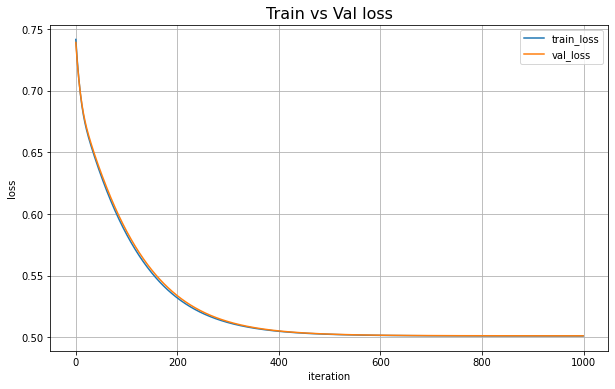

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

iteration = range(len(train_loss_history))
plt.figure(figsize = (10,6))
plt.plot(iteration, train_loss_history, label = 'train_loss')
plt.plot(iteration, val_loss_history, label = 'val_loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.title('Train vs Val loss', size = 16)
plt.grid()
plt.show()

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

### predict

In [44]:
data.head(10)

,user,item,label
2416,135777,278542,0
1443,71675,113907,1
6036,5030,81042,0
7073,19517,181425,0
9136,120281,595778,0
7285,137875,199101,0
9375,43609,179511,0
3563,92656,347366,0
3936,126402,92001,0
5215,67878,170826,0


In [45]:
val_data.head(10)

,user,item,label
739,86745,16128,1
9354,44721,283610,0
7645,107892,445063,0
9502,90617,171677,0
24,38198,439,1
860,54174,899,1
9462,57734,482988,0
8883,126343,484500,0
439,66878,4387,1
7640,84008,87391,0


In [49]:
MLP_model(torch.LongTensor(list(data.user[:10])).to(device),torch.LongTensor(list(data.item[:10])).to(device))#[0][0].item()

tensor([[-2.1818e-01, -1.6295e+00],
        [-7.8358e-01, -6.1022e-01],
        [-7.8624e-01, -6.0799e-01],
        [-1.9625e-01, -1.7249e+00],
        [-7.6729e-04, -7.1731e+00],
        [-6.8424e-05, -9.5893e+00],
        [-4.2775e-04, -7.7571e+00],
        [-9.9193e-04, -6.9163e+00],
        [-2.1619e-02, -3.8450e+00],
        [-2.9214e-04, -8.1386e+00]], grad_fn=<LogSoftmaxBackward0>)

In [50]:
MLP_model(torch.LongTensor(list(val_data.user[:10])).to(device),torch.LongTensor(list(val_data.item[:10])).to(device))#[0][0].item()

tensor([[-6.3763e-01, -7.5192e-01],
        [-3.9526e-01, -1.1193e+00],
        [-1.9708e-01, -1.7211e+00],
        [-4.0769e-05, -1.0107e+01],
        [-7.7742e-01, -6.1543e-01],
        [-9.0088e-03, -4.7141e+00],
        [-5.3484e-02, -2.9550e+00],
        [-1.8963e-01, -1.7560e+00],
        [-2.8629e-01, -1.3905e+00],
        [-5.3393e-02, -2.9567e+00]], grad_fn=<LogSoftmaxBackward0>)

---

- 추천 함수 짜기 참고 코드

In [ ]:
# test plylst_1에 대한 예측 값들
# class 1에 속할 log확률 값이 큰 순으로 100개를 나열하여 인덱스를 뽑으면 됨
nid = 115071
tmp = MLP_model(torch.LongTensor([nid]*638336).to(device), torch.LongTensor(list(range(638336))).to(device)).data

In [294]:
rec_list_all = []
for idx, prob in tqdm(enumerate(tmp)):
    rec_list_all.append([idx, prob[1].item()])

638336it [00:13, 45665.51it/s]


In [ ]:
rec_list_all

In [295]:
from operator import itemgetter
rec_list_300 = sorted(rec_list_all, key = itemgetter(1), reverse = True)[:300]
rec_list_300[:10]

[[384154, -0.0003800861886702478],
 [575905, -0.0004911408759653568],
 [539496, -0.0006094505661167204],
 [529709, -0.0006177900941111147],
 [528340, -0.0007133323233574629],
 [283460, -0.0008760428754612803],
 [415423, -0.0011381583753973246],
 [465610, -0.0011607821797952056],
 [69033, -0.0012172202114015818],
 [365633, -0.0012654400197789073]]

In [200]:
from operator import itemgetter

def recommend_ncf(nid, song_model = model):  #, tag_model = tag_model
    ##### 노래추천 #####
    song_tmp = model(torch.LongTensor([nid]*638336).to(device), torch.LongTensor(list(range(638336))).to(device)).data # 모델에서 결과 예측 (확률값 받아오기)

    rec_list_all = []  # 인덱스와 log(확률값) 넣어주기
    for idx, prob in enumerate(song_tmp):
        rec_list_all.append([idx, prob[1].item()])
    
    rec_list_300 = sorted(rec_list_all, key = itemgetter(1), reverse = True)[:300] # log(확률값) 큰 순서대로 300개 곡 짜르기
    rec_list_300[:5]
    
    exist_sid = plylst_train.loc[nid]['songs_id'] # 이미 들어 있던 곡 파악하기

    final_rec_songs = [] # 마지막으로 추천해줄 100개의 곡 리스트 만들기

    for sid, score in rec_list_300: # 300곡중 이미 들어있던 곡 제외하고 100개 추천해주기
        if sid not in exist_sid:
            final_rec_songs.append(song_sid_id[sid])
            if len(final_rec_songs) == 100:
                break

    return plylst_nid_id[nid], final_rec_songs

In [ ]:
from tqdm import tqdm
answer = []
for idx in tqdm(range(115071,115073)): # test nid start : 115071
    result = recommend_ncf(idx, model)
    answer.append({
        'id' : result[0],
        'songs' : result[1],
        #'tags' : result[2]
    })

In [312]:
plylst.loc[115071]

tags                                                           []
id                                                         118598
plylst_title                                                     
songs           [373313, 151080, 275346, 696876, 165237, 52593...
like_cnt                                                     1675
updt_date                                 2019-05-27 14:14:33.000
nid                                                        115071
songs_id        [82770, 73350, 49850, 283466, 38811, 14654, 83...
tags_id                                                        []
Name: 115071, dtype: object

In [315]:
song_meta.loc[373313]

song_gn_dtl_gnr_basket                     [GN2207, GN1501, GN1506, GN1509]
issue_date                                                         20150101
album_name                Walt Disney Records The Legacy Collection: Pin...
album_id                                                            2308104
artist_id_basket                                                   [353277]
song_name                                           I&#39;ve Got No Strings
song_gn_gnr_basket                                         [GN1500, GN2200]
artist_name_basket                                           [Dickie Jones]
id                                                                   373313
Name: 373313, dtype: object

In [308]:
song_meta.loc[456036]

song_gn_dtl_gnr_basket    [GN1502, GN1501]
issue_date                        20061017
album_name                          타짜 OST
album_id                            328956
artist_id_basket                    [7343]
song_name                             꽃의 춤
song_gn_gnr_basket                [GN1500]
artist_name_basket                   [장영규]
id                                  456036
Name: 456036, dtype: object

In [316]:
answer[0]

IndexError: ignored

---